# Step 2

In step 2 you will be using **Pytorch** to import MNIST, train a neural network on MNIST, find examples that "fool" that trained network, and, if you're a 6505 student, propose a way to deal with these examples.

## Question 1

In [202]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import copy

In [203]:
#batch size
TRAINING_BATCH_SIZE=64
TESTING_BATCH_SIZE=64
PERTURBATION_BATCH_SIZE=1 
EPOCHS = 5

Start by importing both the training and testing MNIST datasets using DataLoaders and the torchvision provided datasets. You can set both the training and testing batch size to be whatever you feel is best.

In [204]:
#downloads MNIST dataset
train_dataset = datasets.MNIST("./root", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.MNIST("./root", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_dataset, perturbation_dataset = random_split(train_dataset, [50000, 10000])

In [205]:
#dataloader helps to takeout batch data (features + labels) from the given dataset
train_dataloader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TESTING_BATCH_SIZE, shuffle=True)
perturbation_dataloader = DataLoader(perturbation_dataset, batch_size=PERTURBATION_BATCH_SIZE, shuffle=False)

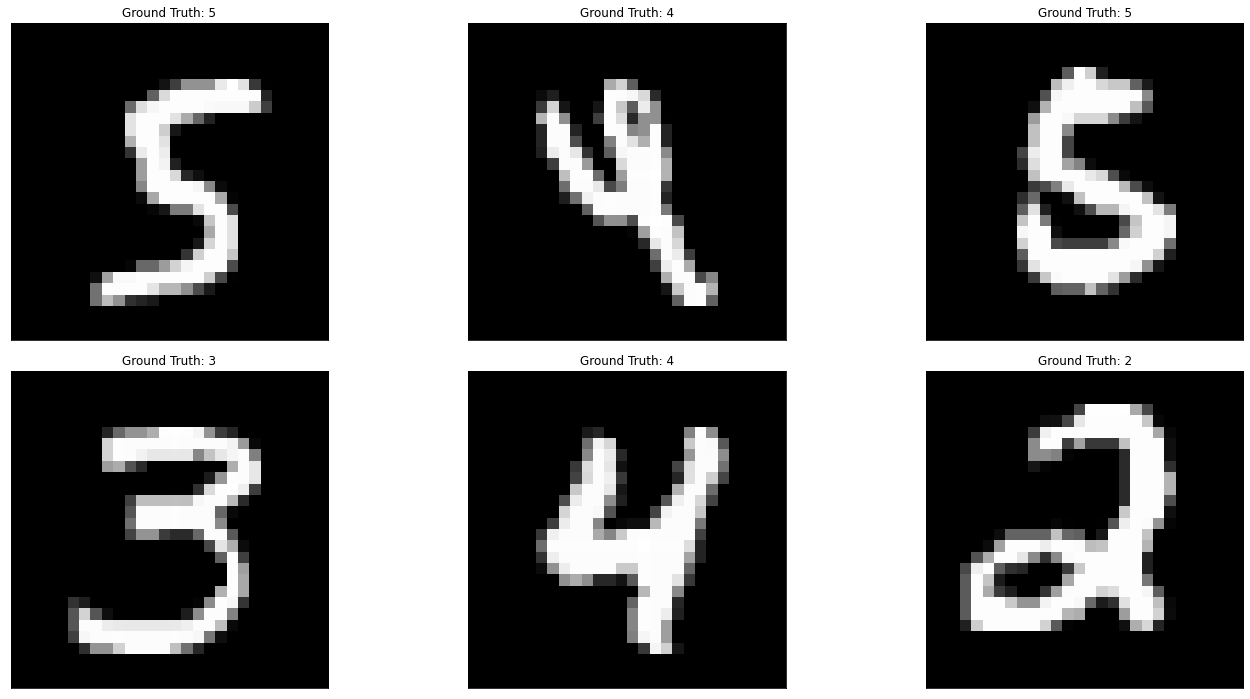

In [206]:
#let's see how the images are looking like
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure(figsize=(20,10))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Question 2

Define a network with the following architecture:

Conv2d (input channels=1, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

In [207]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 15, kernel_size=5)
        self.conv2 = nn.Conv2d(15, 30, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(480, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 480)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## Question 3

Train the network you defined in the previous question on MNIST, using the optimizer and the number of training epochs you deem appropriate. Use a cross-entropy loss. Each epoch test your model on the testing dataset and print the value of the accuracy that you achieve. Produce a plot of the loss against the number of epochs.

**Note**: Do not be overly worried about the accuracy that you achieve with your model. It should be upwards of 95% at the very least, but you won't get bonus marks for training a model that has 99.x% accuracy.

In [208]:
network = CNN()
log_interval = 50
loss_func = F.nll_loss
optimizer = optim.Adam(network.parameters(), lr = 0.0005)  

In [209]:
train_losses = []
test_losses = []

In [210]:
def train(epoch):
  network.train()
  train_loss = 0
  for batch_idx, (data, target) in enumerate(train_dataloader):
    optimizer.zero_grad()
    output = network(data)
    train_loss = loss_func(output, target)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_dataloader.dataset),100. * batch_idx / len(train_dataloader), train_loss.item()))
      

In [211]:
def test(test_dataloader):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_dataloader:
      output = network(data)
      test_loss += loss_func(output, target)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_dataloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_dataloader.dataset), 100. * correct / len(test_dataloader.dataset)))

In [212]:
test(test_dataloader)
for epoch in range(0, EPOCHS):
  train(epoch)
  test(test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0363, Accuracy: 876/10000 (9%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.341431
Train Epoch: 0 [3200/50000 (6%)]	Loss: 1.753516
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.007059
Train Epoch: 0 [9600/50000 (19%)]	Loss: 0.690968
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.626720
Train Epoch: 0 [16000/50000 (32%)]	Loss: 0.585802
Train Epoch: 0 [19200/50000 (38%)]	Loss: 0.491245
Train Epoch: 0 [22400/50000 (45%)]	Loss: 0.391424
Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.435165
Train Epoch: 0 [28800/50000 (58%)]	Loss: 0.363820
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.315391
Train Epoch: 0 [35200/50000 (70%)]	Loss: 0.350129
Train Epoch: 0 [38400/50000 (77%)]	Loss: 0.337425
Train Epoch: 0 [41600/50000 (83%)]	Loss: 0.304693
Train Epoch: 0 [44800/50000 (90%)]	Loss: 0.502934
Train Epoch: 0 [48000/50000 (96%)]	Loss: 0.206598

Test set: Avg. loss: 0.0024, Accuracy: 9540/10000 (95%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.369733
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.237985
Tr

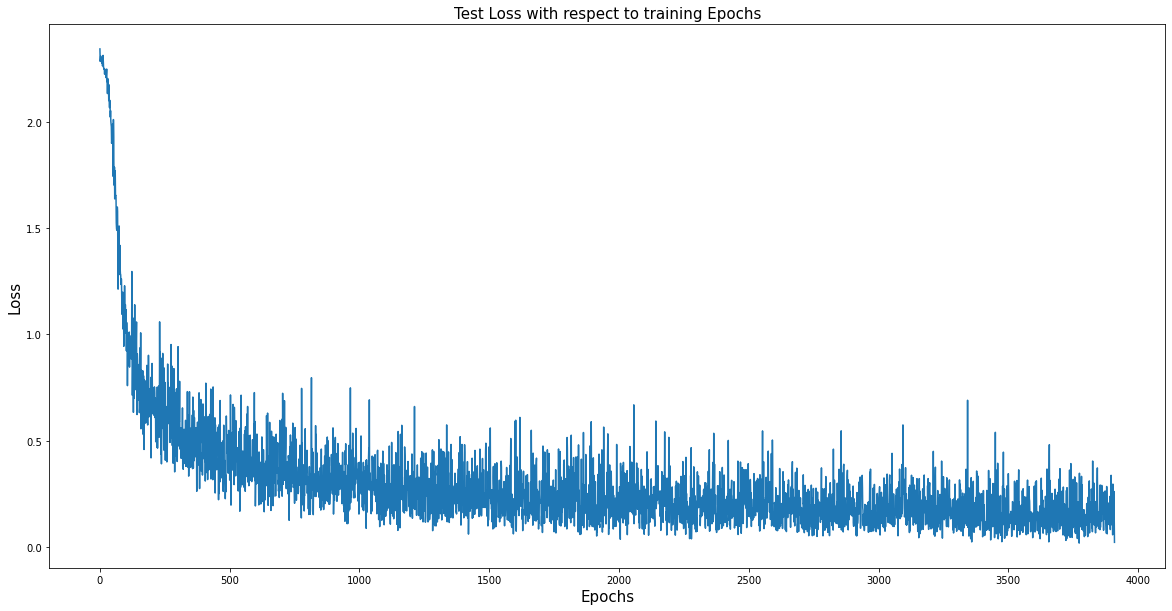

In [213]:
plt.figure(figsize=(20,10))
plt.plot(range(len(train_losses)), train_losses)
plt.title("Test Loss with respect to training Epochs", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

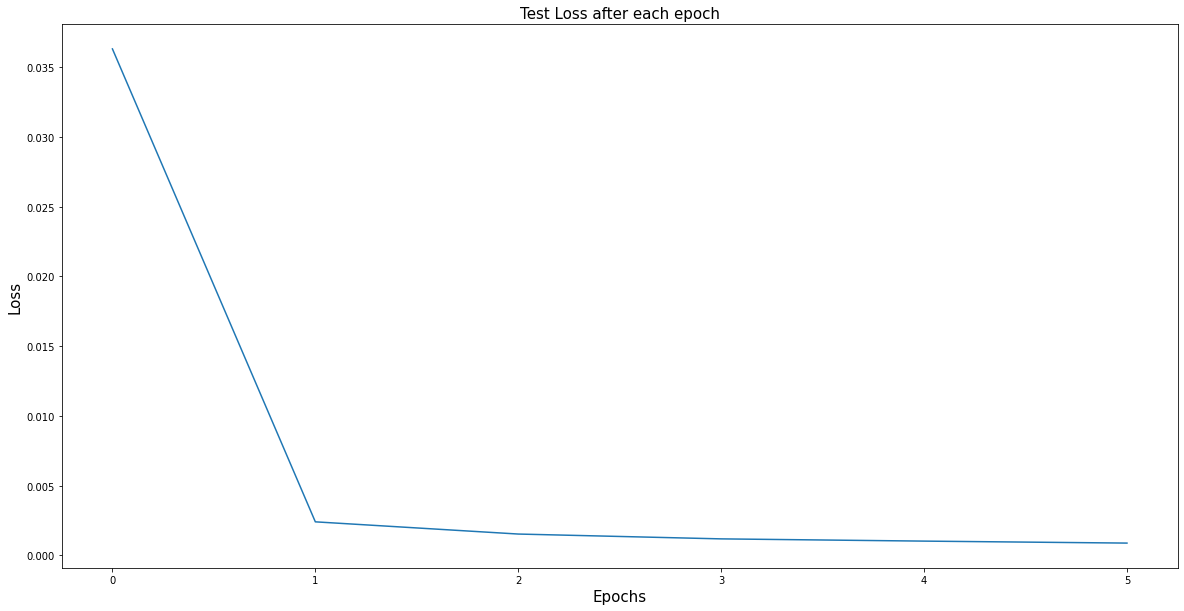

In [214]:
plt.figure(figsize=(20,10))
plt.plot(range(len(test_losses)), test_losses)
plt.title("Test Loss after each epoch".format(EPOCHS), fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

## Question 4

### Part 1

Suppose that you have a fully trained network, and that you wanted to find images that "fooled" it, i.e., images that are misclassified by your network.

One simple approach would be to take an input image, and then alter it in the direction of ascent of the gradient of the loss w.r.t to the pixels of that input image. Mathematically:

$
\begin{equation} \label{pert}
x^´ = x + \epsilon \,\text{sign}\left[\nabla_x \mathcal{L(\theta,x,y}) \right]
\end{equation}
$,

where $x^´$ is the (perturbed) image you hope will fool the classifier, $x$ is the input image, $y$ is the label of the original image, $\theta$ are the network parameters, $\epsilon$ is a hyperparameter controlling the strength of the perturbation, and $\mathcal{L}$ is the loss.

Implement this in Pytorch, using the model you trained in question 3. Generate one $x'$ for all the images in the MNIST testing set, keep the $x^´$ that sucessfully fool your model, alongside their original labels and their predicted (wrong) labels, and print out the accuracy of your model in the perturbed testing set (all the $x^´$ obtained from the images in the original testing set using the equation above), for the following epsilons: $\epsilon = 0,0.05,0.15,0.25$

**Hint**: A line of code similar to "data.requires_grad = True" is needed somewhere in your solution

In [215]:
# #four different values of epsilon
epsilons = [0,0.05,0.15,0.25]

In [216]:
#noise generation
def noiseGenerator(epsilon, grad):
  return epsilon*torch.sign(grad)

#adding noise/perturbution to origina data
def perturbedData(data, epsilon):
  grad = data.grad.data
  perturbed_data = data + noiseGenerator(epsilon, grad)
  return perturbed_data

In [217]:
#testing model on 10k examples (perturbed) 
def p_test(netwrok, dataloader,  epsilon):
    network.eval()

    examples = []
    fooled_examples = []
    correct = 0

    for data, target in dataloader:
      #to store grads dL/dx
      data.requires_grad = True
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]

      #discarding examples where model has given wrong prediction before perturbation
      if pred.item() != target.item():
        continue

      test_loss = loss_func(output, target)
      network.zero_grad()
      test_loss.backward()

      #generating perturbed data with given epsilon value
      p_data = perturbedData(data, epsilon)

      p_output = network(p_data)
      p_pred = p_output.data.max(1, keepdim=True)[1]

      #here I'm only counting correct predictions after perturbation
      if p_pred.item() == target.item():
        correct +=1

        #when epsilon = 0
        if (epsilon == 0) and (len(examples) < 5):
          adv_ex = p_data.squeeze().detach().numpy()
          examples.append( (pred.item(), p_pred.item(), adv_ex) )
      else:
        #when epsilon != 0 && predictions are wrong compared to the targets (IMAGES WHICH HAS FOOLED THE NETWORK)
        if len(examples) < 5:
          adv_ex = p_data.squeeze().detach().numpy()
          examples.append( (pred.item(), p_pred.item(), adv_ex) )

    
    final_acc = correct/float(len(dataloader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(perturbation_dataloader), final_acc))

    return final_acc, examples

In [218]:
examples = []
accuracies = []

for e in epsilons:
    acc, ex = p_test(network, perturbation_dataloader, e)
    accuracies.append(acc)
    examples.append(ex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	Test Accuracy = 9817 / 10000 = 0.9817
Epsilon: 0.05	Test Accuracy = 9022 / 10000 = 0.9022
Epsilon: 0.15	Test Accuracy = 4407 / 10000 = 0.4407
Epsilon: 0.25	Test Accuracy = 937 / 10000 = 0.0937


Here, as we started to test our earlier trained model with epsilon = {0.15, 0.25}, The accuracy of the model reduced very drastically. 

### Part 2

Show some of the images that fooled your network in part 1 (plt.imshow will come in handy), making sure to include both what their original and perturbed labels were in the title of your plot. Does it make sense to you that these images are fooling your network? Why or why not?

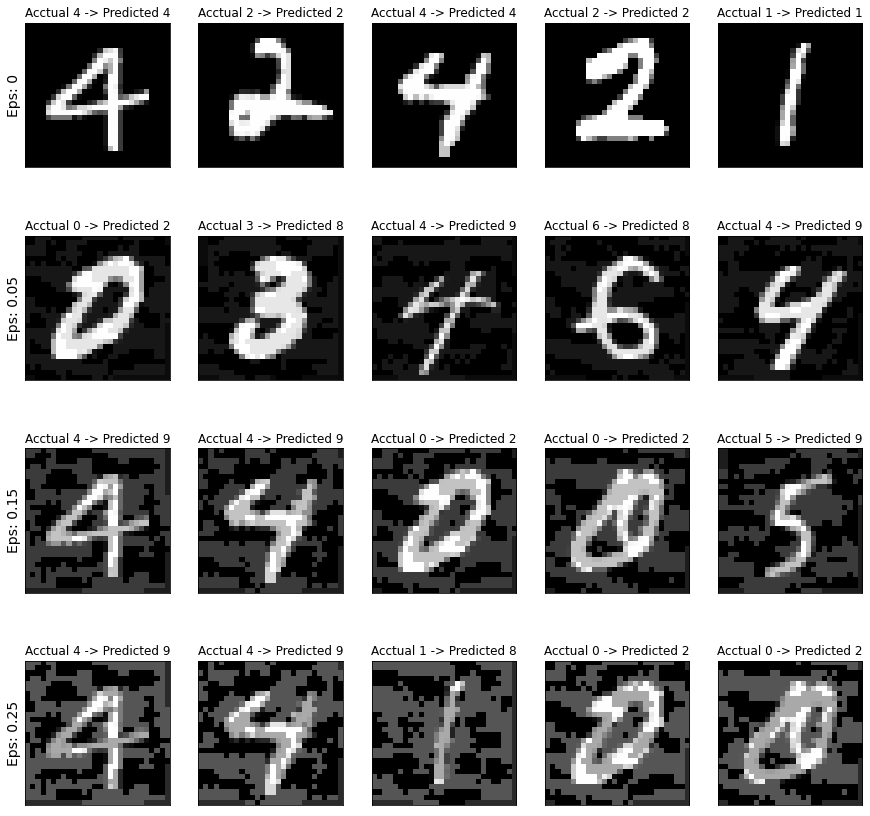

In [219]:
cnt = 0
plt.figure(figsize=(15,15))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("Acctual {} -> Predicted {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.show()

#Does it make sense to you that these images are fooling your network? Why or why not?

<h3>Yes, It does make sense to me that the perturbed images are fooling the networks.</h4>
<p>According to my knowledge, In regular model training we do calculate gradient of Loss function with respect to the input and we try to go into the opposite direction of the gradient (in order to reduce loss). Here, we are going in the direction of the gradient so I think it will definitely increase the loss and reduce the model accuracy.</p>
<p>Even a littel movement in the direction of the gradient will fool the model to assume that it's seeing something different and it's a different class.</p>







References:


Adversarial example generation¶. Adversarial Example Generation - PyTorch Tutorials 1.11.0+cu102 documentation. (n.d.). Retrieved March 16, 2022, from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html 


Adversarial attacks with FGSM (fast gradient sign method). PyImageSearch. (2021, April 17). Retrieved March 16, 2022, from https://pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/#:~:text=How%20does%20the%20Fast%20Gradient,and%20targeted%20adversarial%20attack%20tutorials 

Jason Lin, &amp; Dilara Soylu. (n.d.). Exploring Fast Gradient Sign Method. React app. Retrieved March 20, 2022, from http://jlin.xyz/advis/ 

## Question 5 (6505 only)

Can you think of a way to make your network more robust to these perturbed images? Does your proposal have drawbacks? Run any experiments you feel are needed to prove your statements.

**Note**: You are not expected to find a perfect solution, just something that makes sense and has some evidence backing it up. You will be marked on the persuasiveness of your argument/experiments and how much sense your proposal makes, not the overall improvements in robustness you achieve (however, if your proposal worsens the problem, then that's a pretty solid hint you're going in the wrong direction).

**ANSWER:**

<b>What could be the solution?</b>
<p>After gathering some knowledge about the Attacks and the defensive techniques, I have came across many solutions (not 100% effective) like training the network with such perturbed images can increase classification accuracy. It's known as <b>Adversarial training</b>. Adversarial data is the data on which the model will make wrong predictions. If we train our models to learn to identify such adversarial images as well, we might get partial sucess in preventing the model from falling off againts such attacks.</P>
<p>For, testing the trained model. I am using the <b>testing dataset in halfs.</b> Every batch will be divided into <b>[half pertubed sample + half normal samples]</b>.<P>
<b>Does your proposal have any drawbacks?</b>
<p>One thing I'm not sure about this approach is the epsilon value. I know that epsilon in for strength of the noice that we are adding in the original data. If I choose to train my model on two to three different epsilon values (for example 0.05, 0.10, 0.01), it might fail to predict correctly on higher stregth of noise.</p>
<p>Secondly, I am not sure about efficiency of the solution. If we get 1 million training samples, and we want to do adversarial training. We might have to generate data samples n times. (n is the number of epsilon values).</p>

In [220]:
train_losses = []
test_losses = []
optimizer = optim.Adam(network.parameters(), lr = 0.0005)
pretrained_model_train = copy.deepcopy(network)

In [221]:
def perturbedDataGenerator(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    test_loss = loss_func(output, target)
    test_loss.backward()
    p_data = perturbedData(data, epsilon)
    return p_data

In [222]:
def perturbed_training(i, e):
    for batch_idx, (data, target) in enumerate(train_dataloader):
        train_loss = 0
        data = perturbedDataGenerator(pretrained_model_train, data, target, e)
        network.train()
        optimizer.zero_grad()
        output = network(data)
        train_loss = loss_func(output, target)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(i, batch_idx * len(data), len(train_dataloader.dataset),100. * batch_idx / len(train_dataloader), train_loss.item()))
          

In [223]:
def perturbed_testing(e):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_dataloader:
      data[:32] = perturbedDataGenerator(pretrained_model_train, data[:32], target[:32], e)
      output = network(data)
      test_loss += loss_func(output, target)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss.detach().numpy())
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_dataloader.dataset), 100. * correct / len(test_dataloader.dataset)))

In [224]:
for e in [0.10, 0.15, 0.25]:
  perturbed_testing(e)
  for i in range(5):
      print("Current Epsilon: {}".format(e))
      perturbed_training(i, e)
      perturbed_testing(e)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0078, Accuracy: 8500/10000 (85%)

Current Epsilon: 0.1
Train Epoch: 0 [0/50000 (0%)]	Loss: 1.320165
Train Epoch: 0 [6400/50000 (13%)]	Loss: 0.486731
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.519452
Train Epoch: 0 [19200/50000 (38%)]	Loss: 0.610480
Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.478323
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.474796
Train Epoch: 0 [38400/50000 (77%)]	Loss: 0.384189
Train Epoch: 0 [44800/50000 (90%)]	Loss: 0.282325

Test set: Avg. loss: 0.0018, Accuracy: 9656/10000 (97%)

Current Epsilon: 0.1
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.257254
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.245035
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.137223
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.180977
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.202994
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.108039
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.187676
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.163407

Test set: Avg. loss: 0.0008, Accuracy: 9849/10000 (98

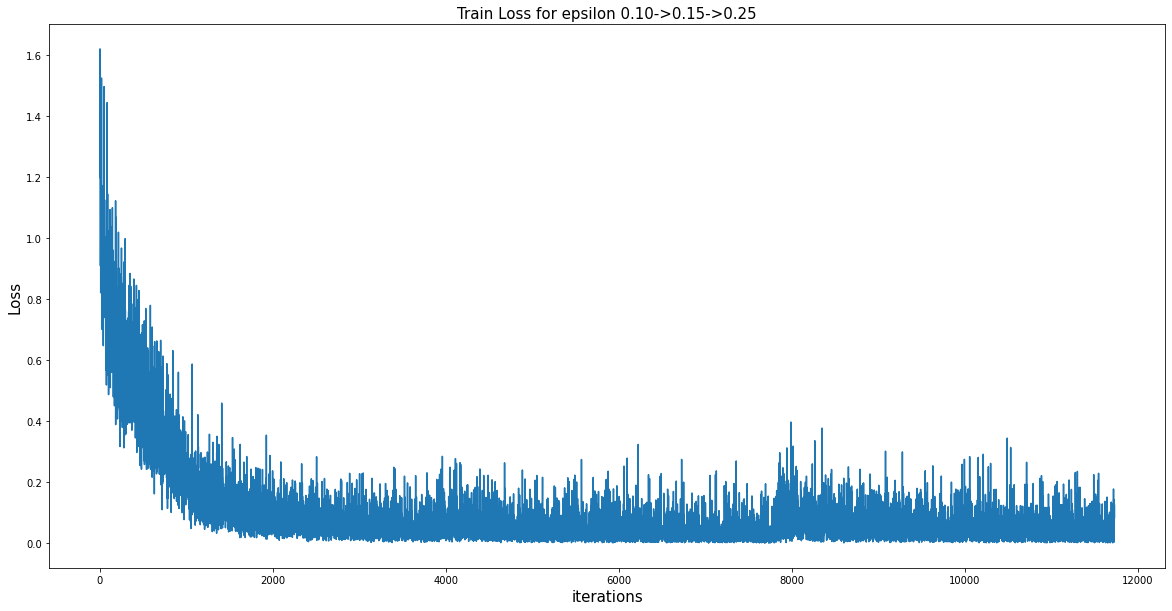

In [235]:
plt.figure(figsize=(20,10))
plt.plot(range(len(train_losses)), train_losses)
plt.title("Train Loss for epsilon 0.10->0.15->0.25".format(EPOCHS), fontsize=15)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

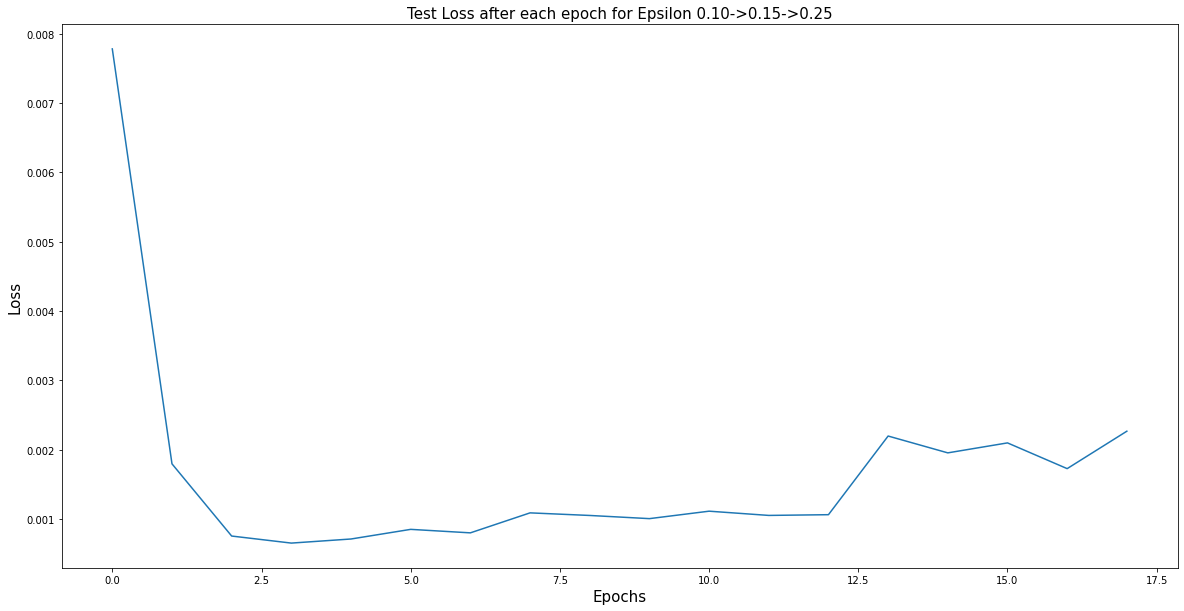

In [236]:
plt.figure(figsize=(20,10))
plt.plot(range(len(test_losses)), test_losses)
plt.title("Test Loss after each epoch for Epsilon 0.10->0.15->0.25".format(EPOCHS), fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In testing, 50% of the samples are the normal one and other's are the perturbed ones. the model is doing good on Advarsarial data as well. 

Resources:

Park, S., &amp; So, J. (n.d.). On the Effectiveness of Adversarial Training in Defending against Adversarial Example Attacks for Image Classification. applsci-10-08164-v2.pdf - applied sciences Article Antioxidant and Potentially Anti-Inflammatory Properties in Pasta Fortified with Onion Skin Monika | Course Hero. Retrieved March 18, 2022, from https://www.coursehero.com/file/93010478/applsci-10-08164-v2pdf/ 